# In the name of Allah

## Mahdi CS 313
## 1404.07.26

## Anaheim Network Analysis + RL Environment Notebook


### Step 0: Install Dependencies (Colab or Local)


In [1]:
!pip install networkx pandas matplotlib requests stable-baselines3 gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.8 MB/s eta 0:00:00


### Step 1: Import Libraries


In [2]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
import requests, zipfile, io, os

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Step 2: Download Anaheim Dataset Automatically
[how-do-i-read-a-response-from-python-requests?](https://stackoverflow.com/questions/18810777/how-do-i-read-a-response-from-python-requests?newreg=ced4813e0e2d4e73a7b3b8b9c053182d)

In [3]:
url = "https://github.com/bstabler/TransportationNetworks/archive/refs/heads/master.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall("./data")

network_path = "./data/TransportationNetworks-master/Anaheim"
print("Dataset extracted to:", network_path)

Dataset extracted to: ./data/TransportationNetworks-master/Anaheim


### ✅ Step 3: Parse Network File (.net)


In [6]:
network_file = os.path.join(network_path, "Anaheim_net.tntp")
G = nx.DiGraph()
with open(network_file, 'r') as f:
    for line in f:
        if line.strip().startswith('~') or line.strip() == '' or line.startswith('<'):
            continue
        parts = line.strip().split()
        if len(parts) >= 5:
            u = int(parts[0])
            v = int(parts[1])
            capacity = float(parts[2])
            G.add_edge(u, v, capacity=capacity)

print(f" Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


 Graph loaded: 416 nodes, 914 edges


### Step 4: Basic Network Statistics


In [7]:
print("\n--- Basic Statistics ---")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Average degree:", sum(dict(G.degree()).values())/G.number_of_nodes())
print("Is strongly connected:", nx.is_strongly_connected(G))



--- Basic Statistics ---
Nodes: 416
Edges: 914
Average degree: 4.394230769230769
Is strongly connected: True


### Step 5: Gomory–Hu Tree for Bottlenecks
[NetworkX - Gomory_hu_tree](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.flow.gomory_hu_tree.html?utm_source=chatgpt.com)




In [9]:
UG = G.to_undirected()
ghtree = nx.gomory_hu_tree(UG)
mincuts = sorted(ghtree.edges(data=True), key=lambda x: x[2]['weight'])

print("\n--- Top 5 Minimum Cuts (Bottlenecks) ---")
for i, (u, v, data) in enumerate(mincuts[:5]):
    print(f"{i+1}. Edge ({u}, {v}) - Min-Cut Capacity: {data['weight']}")



--- Top 5 Minimum Cuts (Bottlenecks) ---
1. Edge (8, 411) - Min-Cut Capacity: 5400.0
2. Edge (411, 410) - Min-Cut Capacity: 5400.0
3. Edge (11, 309) - Min-Cut Capacity: 5400.0
4. Edge (309, 308) - Min-Cut Capacity: 5400.0
5. Edge (12, 275) - Min-Cut Capacity: 5400.0


### Step 6: Plot Graph


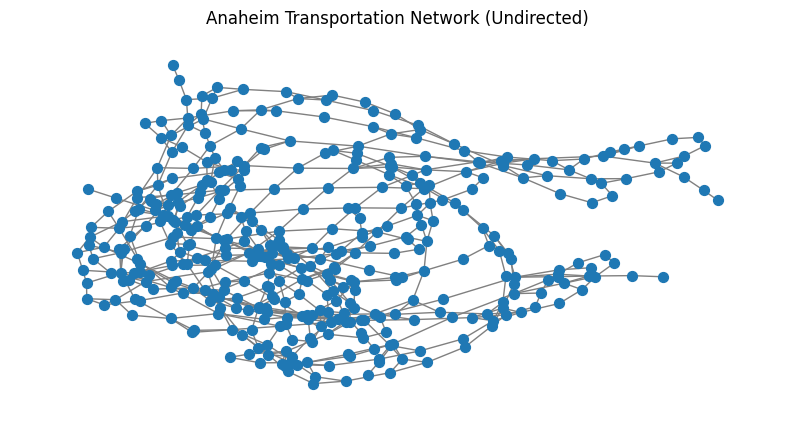

In [10]:
plt.figure(figsize=(10,5))
plt.title("Anaheim Transportation Network (Undirected)")
pos = nx.spring_layout(UG, seed=42)
nx.draw(UG, pos, node_size=50, edge_color='gray', with_labels=False)
plt.show()

### Step 7: Define RL Environment (Gym-like)


In [11]:
class NetworkResilienceEnv(gym.Env):
    """A simple environment where the agent selects edges to increase capacity."""
    metadata = {"render_modes": ["human"]}

    def __init__(self, graph, bottlenecks, capacity_increase=10):
        super(NetworkResilienceEnv, self).__init__()
        self.graph = graph.copy()
        self.bottlenecks = bottlenecks
        self.capacity_increase = capacity_increase
        self.action_space = spaces.Discrete(len(bottlenecks))
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(len(bottlenecks),), dtype=np.float32)
        self.reset()

    def _get_obs(self):
        return np.array([self.graph[u][v]['capacity'] for u,v,_ in self.bottlenecks], dtype=np.float32)

    def _network_score(self):
        UG = self.graph.to_undirected()
        tree = nx.gomory_hu_tree(UG)
        return min([d['weight'] for _,_,d in tree.edges(data=True)])

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.graph = G.copy()
        self.initial_score = self._network_score()
        return self._get_obs(), {}

    def step(self, action):
        u,v,_ = self.bottlenecks[action]
        self.graph[u][v]['capacity'] += self.capacity_increase
        reward = self._network_score() - self.initial_score
        terminated = True
        truncated = False
        return self._get_obs(), reward, terminated, truncated, {}

    def render(self):
        print("Current bottleneck capacities:", self._get_obs())

### Step 8: Instantiate Environment


In [12]:
bottlenecks_top5 = mincuts[:5]
env = NetworkResilienceEnv(G, bottlenecks_top5)
obs, _ = env.reset()
print("Initial Observation:", obs)

Initial Observation: [5400. 5400. 5400. 5400. 5400.]


### Step 9: Train a Simple DQN Agent


In [ ]:
model = DQN("MlpPolicy", env, verbose=1, learning_rate=1e-3, buffer_size=1000)
model.learn(total_timesteps=500)

### Step 10: Evaluate Agent
obs, _ = env.reset()
for i in range(2):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    print(f"Step {i+1}: action={action}, reward={reward}")
    if done:
        obs, _ = env.reset()

print("\n✅ RL Environment and simple agent demo completed.")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 10       |
|    total_timesteps  | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 0        |
|    time_elapsed     | 20       |
|    total_timesteps  | 8        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | 0      

# DQN Agent for Graph-based Transportation Network (Anaheim)

## Comparison between Traditional Minimum-Cut & RL-based Routing

In [ ]:
import gym
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim

### 1. Build Simple Graph Env

In [ ]:
class GraphEnv(gym.Env):
def __init__(self, G: nx.Graph, source: int, target: int):
super(GraphEnv, self).__init__()
self.G = G
self.source = source
self.target = target
self.nodes = list(G.nodes())
self.action_space = gym.spaces.Discrete(len(self.nodes))
self.observation_space = gym.spaces.Discrete(len(self.nodes))
self.reset()


def reset(self):
self.current_node = self.source
return self.current_node


def step(self, action):
if action in self.G[self.current_node]:
cost = self.G[self.current_node][action].get('weight', 1)
self.current_node = action
reward = -cost
done = (self.current_node == self.target)
return self.current_node, reward, done, {}
else:
# Invalid move penalty
return self.current_node, -5, False, {}

### 2. DQN Agent Definition

In [ ]:
class DQN(nn.Module):
return self.fc3(x)


class DQNAgent:
def __init__(self, state_size, action_size):
self.state_size = state_size
self.action_size = action_size
self.memory = deque(maxlen=2000)
self.gamma = 0.95
self.epsilon = 1.0
self.epsilon_min = 0.01
self.epsilon_decay = 0.995
self.model = DQN(state_size, action_size)
self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
self.criterion = nn.MSELoss()


def act(self, state):
if np.random.rand() <= self.epsilon:
return np.random.randint(self.action_size)
state = torch.FloatTensor(state).unsqueeze(0)
act_values = self.model(state)
return torch.argmax(act_values[0]).item()


def remember(self, s, a, r, s_, done):
self.memory.append((s, a, r, s_, done))


def replay(self, batch_size=32):
if len(self.memory) < batch_size:
return
minibatch = random.sample(self.memory, batch_size)
for s, a, r, s_, done in minibatch:
target = r
if not done:
s_ = torch.FloatTensor(s_).unsqueeze(0)
target = r + self.gamma * torch.max(self.model(s_)[0]).item()
s = torch.FloatTensor(s).unsqueeze(0)
target_f = self.model(s).clone()
target_f[0][a] = target
output = self.model(s)
loss = self.criterion(output, target_f)
self.optimizer.zero_grad()
loss.backward()
self.optimizer.step()
if self.epsilon > self.epsilon_min:
self.epsilon *= self.epsilon_decay

### 3. Build Graph + Traditional Baseline

In [ ]:
G = nx.generators.classic.path_graph(6)
for u, v in G.edges():
G[u][v]['weight'] = np.random.randint(1, 10)


source, target = 0, 5
env = GraphEnv(G, source, target)


# Traditional shortest path cost
shortest_path = nx.shortest_path(G, source=source, target=target, weight='weight')
traditional_cost = nx.shortest_path_length(G, source=source, target=target, weight='weight')
print("Traditional path:", shortest_path, "cost=", traditional_cost)

### 4. Train DQN Agent

In [ ]:
### 4. Train DQN Agent

In [ ]:
agent = DQNAgent(state_size=1, action_size=len(G.nodes()))
episodes = 300
rewards_per_episode = []


for e in range(episodes):
state = np.array([env.reset()], dtype=np.float32)
total_reward = 0
for t in range(20):
action = agent.act(state)
next_state, reward, done, _ = env.step(action)
next_state = np.array([next_state], dtype=np.float32)
agent.remember(state, action, reward, next_state, done)
state = next_state
total_reward += reward
if done:
break
agent.replay(32)
rewards_per_episode.append(total_reward)

### 5. Evaluation & Comparison

In [ ]:
def evaluate_dqn(agent, env, n_eval=50):
total_costs = []
for _ in range(n_eval):
state = np.array([env.reset()], dtype=np.float32)
cost = 0
for _ in range(20):
action = agent.act(state)
if action not in env.G[state[0]]:
cost += 5 # penalty
else:
cost += env.G[state[0]][action]['weight']
next_state, _, done, _ = env.step(action)
state = np.array([next_state], dtype=np.float32)
if done:
break
total_costs.append(cost)
return np.mean(total_costs)


dqn_cost = evaluate_dqn(agent, env)

### 6. Plotting Comparison

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(rewards_per_episode)
plt.title("Training Reward per Episode (DQN)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.subplot(1,2,2)
plt.bar(["Traditional", "DQN"], [traditional_cost, dqn_cost])
plt.title("Cost Comparison")
plt.ylabel("Average Cost")
plt.show()


print(f"Traditional method cost: {traditional_cost}")
print(f"DQN average cost after training: {dqn_cost}")